# Oracle Alignment Analysis — Optimization-Induced Uncertainty

**Purpose:** Visualize how compiler optimization (O0 → O1) degrades the quality of
binary↔source function alignment produced by the DWARF oracle and tree-sitter joiner pipeline.

**Data sources per test case per optimization level:**
- `oracle_report.json` / `oracle_functions.json` — DWARF oracle verdicts
- `alignment_report.json` / `alignment_pairs.json` — DWARF↔TS alignment results
- `build_receipt.json` — build metadata and binary sizes

**Scope control:** Set `SELECTED_TESTS` in the config cell to filter test cases.
All downstream plots respond automatically.

In [1]:
## ── Imports & Thesis Plot Style ──────────────────────────────────────────────

from pathlib import Path
import json, textwrap, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)  # seaborn noise

# ── Thesis-ready plot style ──────────────────────────────────────────────────
# Grayscale-friendly 5-colour qualitative palette (ColorBrewer Set2 subset)
PALETTE = {
    "MATCH":      "#66c2a5",
    "AMBIGUOUS":  "#fc8d62",
    "NO_MATCH":   "#e78ac3",
    "NON_TARGET": "#8da0cb",
}
PALETTE_ORACLE = {
    "ACCEPT": "#66c2a5",
    "REJECT": "#e78ac3",
    "WARN":   "#fc8d62",
}
OPT_MARKERS = {"O0": "o", "O1": "^", "O2": "s", "O3": "D"}
OPT_COLORS  = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}

THESIS_RC = {
    "font.family":       "serif",
    "font.size":         10,
    "axes.titlesize":    12,
    "axes.labelsize":    10,
    "xtick.labelsize":    9,
    "ytick.labelsize":    9,
    "legend.fontsize":    9,
    "figure.dpi":       120,
    "savefig.dpi":      300,
    "savefig.bbox":     "tight",
    "figure.figsize":   (7, 4.5),
    "axes.spines.top":   False,
    "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)
sns.set_context("paper", rc=THESIS_RC)

# ── Helper: save figure ──────────────────────────────────────────────────────
FIG_DIR = Path("../figures/oracle_analysis")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None):
    """Save current figure as PDF + PNG to FIG_DIR."""
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  → saved {FIG_DIR / name}.{{pdf,png}}")

print("✓ imports & style ready")

✓ imports & style ready


In [2]:
## ── Scope Switch & Data Loading (via data module) ───────────────────────────
import sys
sys.path.insert(0, str(Path("..").resolve()))

from data import load_dataset, enrich_pairs, compute_verdict_rates

# ▸ Set to None for ALL test cases, or a list like ["t06_recursion_inline"]
SELECTED_TESTS: list[str] | None = None

# ▸ Optimization levels (only O0/O1 have oracle data for now)
OPT_LEVELS = ["O0", "O1"]

# ▸ Only debug variant has oracle data
VARIANT = "debug"

ds = load_dataset(
    Path("../docker/local-files/artifacts/synthetic"),
    test_cases=SELECTED_TESTS,
    opt_levels=OPT_LEVELS,
    variant=VARIANT,
)

# Unpack into notebook-level variables for plotting cells
df_pairs       = enrich_pairs(ds.pairs)      # adds n_candidates, gap_rate
df_non_targets = ds.non_targets
df_report      = compute_verdict_rates(ds.reports)  # adds *_rate columns
df_builds      = ds.builds
tests          = ds.test_cases

scope_label = f"{len(tests)} test case(s)" if len(tests) > 3 else ", ".join(tests)
print(f"✓ scope: {scope_label}  |  opts: {OPT_LEVELS}")
for t in tests:
    print(f"   • {t}")
print(f"✓ loaded {len(df_pairs)} pairs, {len(df_non_targets)} non-targets, "
      f"{len(df_report)} report rows, {len(df_builds)} build rows")

✓ scope: 12 test case(s)  |  opts: ['O0', 'O1']
   • t01_crossfile_calls
   • t02_shared_header_macros
   • t03_header_dominant
   • t04_static_dup_names
   • t05_fptr_callbacks
   • t06_recursion_inline
   • t07_switch_parser
   • t08_loop_heavy
   • t09_string_format
   • t10_math_libm
   • t11_mixed_stress
   • t12_state_machine
✓ loaded 336 pairs, 359 non-targets, 24 report rows, 144 build rows


In [3]:
## ── Data Validation & Plot-Specific Derived Columns ──────────────────────────
# Core derived columns (n_candidates, gap_rate) are added by enrich_pairs()
# in the loading cell above.  Only plot-specific convenience columns here.

if not df_pairs.empty:
    df_pairs["confidence"] = (
        df_pairs["overlap_ratio"] * (1 - df_pairs["gap_rate"])
    ).clip(0, 1)

    df_pairs["is_header_collision"] = df_pairs["reasons"].apply(
        lambda r: "HEADER_REPLICATION_COLLISION" in r
    )
    df_pairs["has_pc_gap"] = df_pairs["reasons"].apply(
        lambda r: "PC_LINE_GAP" in r
    )
    df_pairs["has_multi_file"] = df_pairs["reasons"].apply(
        lambda r: "MULTI_FILE_RANGE_PROPAGATED" in r
    )
    df_pairs["tu_short"] = df_pairs["best_tu_path"].apply(
        lambda p: Path(p).stem if p else ""
    )

print(f"df_pairs:       {df_pairs.shape}")
print(f"df_non_targets: {df_non_targets.shape}")
print(f"df_report:      {df_report.shape}")
print(f"df_builds:      {df_builds.shape}")
print()

# Quick sanity: every selected test × opt should appear in df_report
expected = {(t, o) for t in tests for o in OPT_LEVELS}
actual   = set(zip(df_report["test_case"], df_report["opt"]))
missing  = expected - actual
if missing:
    print(f"⚠ missing report rows: {missing}")
else:
    print("✓ all test×opt combinations present in df_report")

# Show report summary (now includes rate columns from compute_verdict_rates)
display(
    df_report[["test_case","opt","oracle_accept","oracle_reject","oracle_warn",
               "accept_rate","reject_rate",
               "match","ambiguous","no_match","non_target",
               "match_rate","ambiguous_rate","no_match_rate","non_target_rate"]]
    .style.set_caption("Report Summary — Oracle & Alignment Counts + Rates")
)

df_pairs:       (336, 22)
df_non_targets: (359, 6)
df_report:      (24, 23)
df_builds:      (144, 7)

✓ all test×opt combinations present in df_report


,test_case,opt,oracle_accept,oracle_reject,oracle_warn,accept_rate,reject_rate,match,ambiguous,no_match,non_target,match_rate,ambiguous_rate,no_match_rate,non_target_rate
0,t01_crossfile_calls,O0,13,10,0,56.520000,43.480000,11,2,0,10,47.830000,8.700000,0.000000,43.480000
1,t01_crossfile_calls,O1,9,14,0,39.130000,60.870000,9,0,0,14,39.130000,0.000000,0.000000,60.870000
2,t02_shared_header_macros,O0,18,5,0,78.260000,21.740000,9,9,0,5,39.130000,39.130000,0.000000,21.740000
3,t02_shared_header_macros,O1,3,20,1,12.500000,83.330000,1,0,3,20,4.170000,0.000000,12.500000,83.330000
4,t03_header_dominant,O0,18,8,0,69.230000,30.770000,4,14,0,8,15.380000,53.850000,0.000000,30.770000
5,t03_header_dominant,O1,3,28,0,9.680000,90.320000,1,0,2,28,3.230000,0.000000,6.450000,90.320000
6,t04_static_dup_names,O0,17,7,0,70.830000,29.170000,17,0,0,7,70.830000,0.000000,0.000000,29.170000
7,t04_static_dup_names,O1,4,25,0,13.790000,86.210000,1,0,3,25,3.450000,0.000000,10.340000,86.210000
8,t05_fptr_callbacks,O0,10,11,0,47.620000,52.380000,10,0,0,11,47.620000,0.000000,0.000000,52.380000
9,t05_fptr_callbacks,O1,10,13,0,43.480000,56.520000,10,0,0,13,43.480000,0.000000,0.000000,56.520000


---
## Plot 1 — DWARF Oracle Verdict Degradation (O0 → O1)

The DWARF oracle decides which functions are *targetable* for alignment based on
debug info quality. This plot shows the raw impact of optimization **before
alignment even runs**: how many functions does the oracle ACCEPT, REJECT, or WARN?

  → saved ..\figures\oracle_analysis\01_oracle_verdict_degradation_pct.{pdf,png}


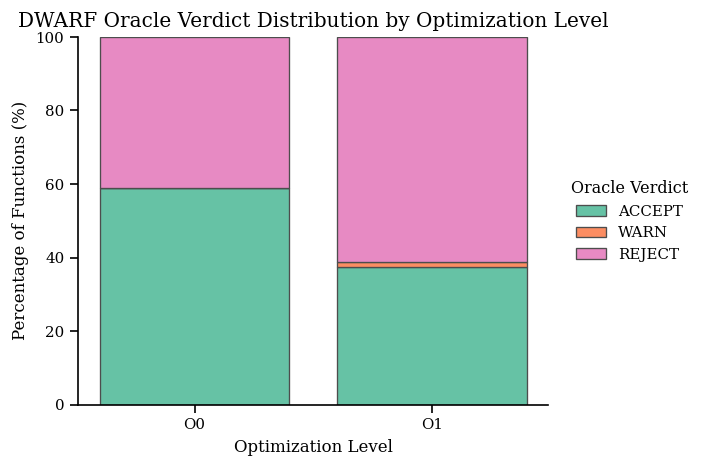

In [4]:
# ── Plot 1: DWARF Oracle Verdict Degradation (Percentage Stacked) ───────────

oracle_melt = df_report.melt(
    id_vars=["test_case", "opt"],
    value_vars=["oracle_accept", "oracle_reject", "oracle_warn"],
    var_name="verdict_raw", value_name="count",
)

oracle_melt["verdict"] = (
    oracle_melt["verdict_raw"]
    .str.replace("oracle_", "")
    .str.upper()
)

# Aggregate counts
oracle_agg = (
    oracle_melt
    .groupby(["opt", "verdict"], as_index=False)["count"]
    .sum()
)

# Compute percentages per opt level
oracle_agg["percent"] = (
    oracle_agg["count"] /
    oracle_agg.groupby("opt")["count"].transform("sum")
) * 100

# Pivot for stacked plotting
oracle_pivot = (
    oracle_agg
    .pivot(index="opt", columns="verdict", values="percent")
    .fillna(0)
)

v_order = ["ACCEPT", "WARN", "REJECT"]
oracle_pivot = oracle_pivot[v_order]

fig, ax = plt.subplots(figsize=(6, 4))

bottom = np.zeros(len(oracle_pivot))
for verdict in v_order:
    vals = oracle_pivot[verdict].values
    ax.bar(
        oracle_pivot.index,
        vals,
        bottom=bottom,
        label=verdict,
        color=PALETTE_ORACLE[verdict],
        edgecolor="0.3"
    )
    bottom += vals

ax.set_ylabel("Percentage of Functions (%)")
ax.set_xlabel("Optimization Level")
ax.set_title("DWARF Oracle Verdict Distribution by Optimization Level")
ax.set_ylim(0, 100)

ax.legend(
    title="Oracle Verdict",
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)


plt.tight_layout()
save_fig("01_oracle_verdict_degradation_pct")
plt.show()


**Interpretation:**
- **ACCEPT** decreases from O0 → O1: under optimization, fewer functions retain DWARF evidence that satisfies the oracle’s “usable target” criteria (e.g., stable code ranges and sufficient line mappings), consistent with effects such as inlining, range fragmentation, and removal/merging of standalone bodies.

- **REJECT** increases: more DWARF subprogram entries fail oracle requirements (e.g., DECLARATION_ONLY, MISSING_RANGE), meaning the function is represented in metadata but lacks a recoverable code range suitable for alignment.

- **WARN** appears at O1: a small subset retains enough evidence to pass filtering but exhibits degraded quality indicators (e.g., fragmented/non-local ranges or ambiguous line mappings), so it is kept as a target with reduced confidence.


---
## Plot 2 — Alignment Outcome Shift (O0 → O1)

The headline plot: how many functions end up in each alignment verdict category
(**MATCH**, **AMBIGUOUS**, **NO_MATCH**, **NON_TARGET**) at each optimization level?

  → saved ..\figures\oracle_analysis\02_alignment_outcome_shift_pct.{pdf,png}


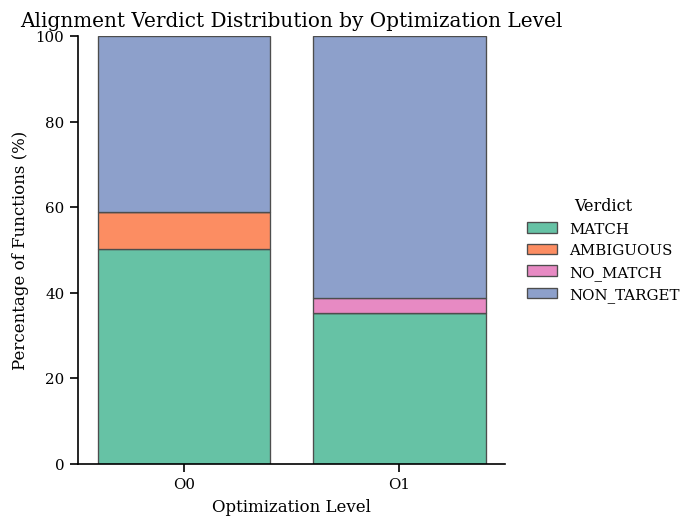

In [5]:
# ── Plot 2: Alignment Outcome Shift (Percentage Stacked) ─────────────────────

verdict_cats = ["MATCH", "AMBIGUOUS", "NO_MATCH", "NON_TARGET"]

align_melt = df_report.melt(
    id_vars=["test_case", "opt"],
    value_vars=["match", "ambiguous", "no_match", "non_target"],
    var_name="verdict_raw", value_name="count",
)
align_melt["verdict"] = align_melt["verdict_raw"].str.upper()

align_agg = (
    align_melt
    .groupby(["opt", "verdict"], as_index=False)["count"]
    .sum()
)

# percentages per opt
align_agg["percent"] = (
    align_agg["count"] /
    align_agg.groupby("opt")["count"].transform("sum")
) * 100

align_pivot = (
    align_agg
    .pivot(index="opt", columns="verdict", values="percent")
    .fillna(0)
)[verdict_cats]

fig, ax = plt.subplots(figsize=(7, 4.5))
bottom = np.zeros(len(align_pivot))

for v in verdict_cats:
    vals = align_pivot[v].values
    ax.bar(
        align_pivot.index, vals, bottom=bottom,
        label=v, color=PALETTE[v], edgecolor="0.3"
    )
    bottom += vals

ax.set_xlabel("Optimization Level")
ax.set_ylabel("Percentage of Functions (%)")
ax.set_title("Alignment Verdict Distribution by Optimization Level")
ax.set_ylim(0, 100)

ax.legend(title="Verdict", frameon=False, loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1]) # type: ignore

save_fig("02_alignment_outcome_shift_pct")
plt.show()


**Interpretation:**
- **MATCH count decreases from O0 → O1:** optimization makes it harder to uniquely
  align binary functions to source.
- **NON_TARGET rises dramatically:** more functions are rejected by the DWARF oracle
  upstream, so they never reach alignment.
- **AMBIGUOUS disappears at O1** while **NO_MATCH appears:** at O0, header-replicated
  functions cause near-ties (AMBIGUOUS); at O1, the same functions fail outright
  because inlining distorts their line mappings below the overlap threshold.

---
## Plot 3 — Reason Composition per Optimization Level

*What kind* of alignment difficulty dominates at each optimization level?
This breaks down the reason tags into a normalized stacked bar.

  → saved ..\figures\oracle_analysis\03_reason_shift_delta_pp.{pdf,png}


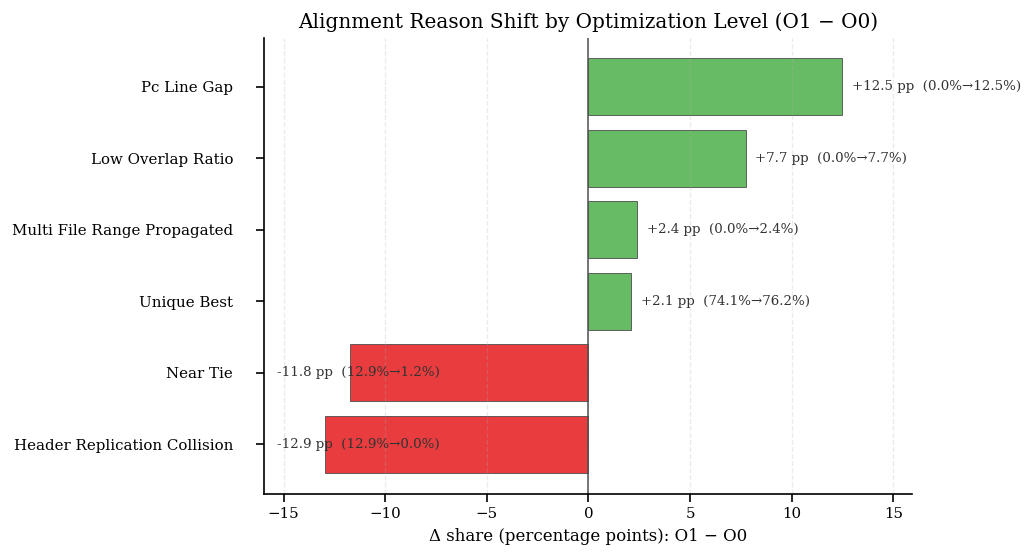

In [6]:
def plot_reason_shift_delta_pp(
    df_report: pd.DataFrame,
    *,
    o0_label: str = "O0",
    o1_label: str = "O1",
    top_k: int = 6,
    figsize: tuple[int, int] = (9, 5),
    out_name: str = "03_reason_shift_delta_pp",
):
    """
    Best version: Diverging bar chart of alignment reason share shift (O1 - O0) in percentage points.
    Fixes:
      - No label overlap (negative labels go into a fixed left column)
      - Bars are not visually compressed (symmetric x-limits around max |Δ|)
      - Layout stays stable (manual margins + tight_layout rect)
    """

    # --- inputs ---
    reason_cols = [c for c in df_report.columns if c.startswith("reason_")]
    if not reason_cols:
        raise ValueError("No reason_* columns found in df_report.")

    reason_nice = {c: c.replace("reason_", "").replace("_", " ").title() for c in reason_cols}

    # Aggregate absolute reason counts per opt
    reason_by_opt = df_report.groupby("opt")[reason_cols].sum().rename(columns=reason_nice)

    # Drop zero-only columns
    reason_by_opt = reason_by_opt.loc[:, (reason_by_opt > 0).any()]
    if reason_by_opt.empty:
        raise ValueError("All reason columns are zero; nothing to plot.")

    # Compute shares (%)
    reason_pct = reason_by_opt.div(reason_by_opt.sum(axis=1), axis=0) * 100

    # Ensure O0/O1 exist
    if o0_label not in reason_pct.index or o1_label not in reason_pct.index:
        raise ValueError(f"Expected opt labels {o0_label}/{o1_label} in df_report['opt'].")

    # --- reduce categories: keep top_k by max share across O0/O1; fold rest into 'Other' ---
    max_share = reason_pct.loc[[o0_label, o1_label]].max(axis=0).sort_values(ascending=False)
    keep = list(max_share.head(top_k).index)
    drop = [c for c in reason_pct.columns if c not in keep]

    if drop:
        reason_by_opt["Other"] = reason_by_opt[drop].sum(axis=1)
        reason_by_opt = reason_by_opt[keep + ["Other"]]

        reason_pct["Other"] = reason_pct[drop].sum(axis=1)
        reason_pct = reason_pct[keep + ["Other"]]
    else:
        reason_by_opt = reason_by_opt[keep]
        reason_pct = reason_pct[keep]

    # --- compute delta (percentage points) ---
    delta_pp = (reason_pct.loc[o1_label] - reason_pct.loc[o0_label]).sort_values() #type: ignore

    # For annotations
    o0_vals = reason_pct.loc[o0_label].reindex(delta_pp.index)
    o1_vals = reason_pct.loc[o1_label].reindex(delta_pp.index)

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)

    y = np.arange(len(delta_pp))
    vals = delta_pp.values.astype(float)

    colors = np.where(vals >= 0, "#4daf4a", "#e41a1c") #type: ignore
    ax.barh(y, vals, color=colors, edgecolor="0.3", linewidth=0.6, alpha=0.85) #type: ignore
    ax.axvline(0, color="0.3", linewidth=0.9)

    ax.set_yticks(y)
    ax.set_yticklabels(delta_pp.index, fontsize=9)
    ax.tick_params(axis="y", pad=14)

    ax.set_xlabel("Δ share (percentage points): O1 − O0")
    ax.set_title("Alignment Reason Shift by Optimization Level (O1 − O0)")

    # --- IMPORTANT: symmetric x-limits so bars don't look "too short" ---
    max_abs = float(np.max(np.abs(vals))) if len(vals) else 1.0
    xpad = max(3.0, max_abs * 0.18)
    ax.set_xlim(-max_abs - xpad, max_abs + xpad)

    # --- layout margins (room for long y labels + left annotation column) ---
    # left margin sized to avoid y-label crowding; keep right margin for positive annotations
    fig.subplots_adjust(left=0.38, right=0.98, top=0.90, bottom=0.14)

    # Annotation positions
    xmin, xmax = ax.get_xlim()
    x_range = xmax - xmin
    neg_x = xmin + 0.02 * x_range       # fixed left column for negative labels
    pos_pad = 0.015 * x_range           # small padding after positive bar end

    # Annotations
    for i, (d, a0, a1) in enumerate(zip(vals, o0_vals.values, o1_vals.values)):
        label = f"{d:+.1f} pp  ({a0:.1f}%→{a1:.1f}%)"
        if d >= 0:
            ax.text(d + pos_pad, i, label,
                    va="center", ha="left", fontsize=8, color="0.2", clip_on=False)
        else:
            ax.text(neg_x, i, label,
                    va="center", ha="left", fontsize=8, color="0.2", clip_on=False)

    # Optional note
    if "Other" in delta_pp.index:
        ax.text(0.99, 0.01, f"Top-{top_k} reasons shown; remainder folded into 'Other'.",
                transform=ax.transAxes, ha="right", va="bottom", fontsize=8, color="0.35")

    # Optional: light x-grid for readability
    ax.grid(axis="x", linestyle="--", alpha=0.25)

    save_fig(out_name)
    plt.show()
plot_reason_shift_delta_pp(df_report)


**Interpretation:**
- **O0 ambiguity is dominated by HEADER_REPLICATION_COLLISION + NEAR_TIE:** inline
  functions from shared headers are compiled into every translation unit, creating
  structurally identical candidates. The ambiguity is *structural*, not stochastic.
- **O1 failures are dominated by PC_LINE_GAP + MULTI_FILE_RANGE_PROPAGATED + LOW_OVERLAP_RATIO:**
  the compiler inlines code across file boundaries, distorts the PC↔line mappings,
  and causes the overlap ratio to drop below the matching threshold (0.7).
- **UNIQUE_BEST still dominates overall** — most functions that survive the oracle
  have clean, unambiguous alignment. The problems concentrate on a predictable subset.

---
## Plot 4 — Match Quality Distribution (overlap_ratio ECDF)

Even among aligned pairs, how does the *quality* of alignment (measured by
`overlap_ratio`) shift between O0 and O1?

  → saved ..\figures\oracle_analysis\04_overlap_ratio_ecdf.{pdf,png}


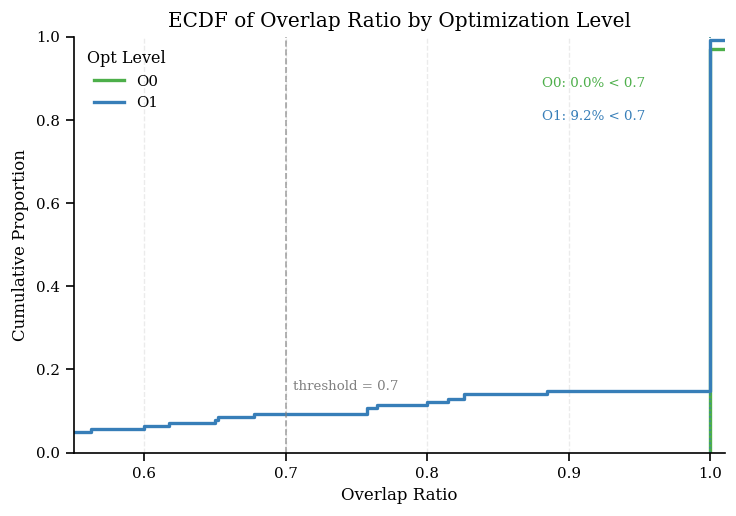

In [7]:
# ── Plot 4: Match Quality Distribution (overlap_ratio ECDF) ──────────────────

df_valid = df_pairs[df_pairs["dwarf_verdict"].isin(["ACCEPT", "WARN"])].copy()

fig, ax = plt.subplots(figsize=(7, 4.5))

y_annot = 0.88
for opt in OPT_LEVELS:
    subset = df_valid[df_valid["opt"] == opt]
    if subset.empty:
        continue

    sns.ecdfplot(
        data=subset, x="overlap_ratio", ax=ax,
        label=opt, color=OPT_COLORS[opt], linewidth=2
    )

    # % below threshold
    p_below = (subset["overlap_ratio"] < 0.7).mean() * 100
    ax.text(0.72, y_annot, f"{opt}: {p_below:.1f}% < 0.7",
            fontsize=8, color=OPT_COLORS[opt], transform=ax.transAxes)
    y_annot -= 0.08

    # median line
    med = subset["overlap_ratio"].median()
    ax.axvline(med, color=OPT_COLORS[opt], linestyle=":", linewidth=1, alpha=0.8)

# Threshold reference line
ax.axvline(0.7, color="gray", linestyle="--", linewidth=1, alpha=0.7)
ax.text(0.705, 0.15, "threshold = 0.7", fontsize=8, color="gray")

ax.set_xlabel("Overlap Ratio")
ax.set_ylabel("Cumulative Proportion")
ax.set_title("ECDF of Overlap Ratio by Optimization Level")
ax.legend(title="Opt Level", frameon=False)

# zoom to informative range
ax.set_xlim(0.55, 1.01)

ax.grid(axis="x", linestyle="--", alpha=0.25)

save_fig("04_overlap_ratio_ecdf")
plt.show()


**Interpretation:**
- **O0 curve hugs the right:** nearly all functions have overlap_ratio = 1.0
  (perfect line coverage).
- **O1 curve shifts left:** a measurable fraction of functions drops below 1.0,
  and some fall below the 0.7 threshold, producing NO_MATCH verdicts.
- **Even among O1 matches, alignment confidence degrades** — the "tail" below 1.0
  represents functions where inlining or optimization has introduced gaps in the
  line-table mapping.

---
## Plot 5 — Gap Severity Distribution (gap_count)

`gap_count` is the number of DWARF line rows in the function's address range that
do *not* map to the best tree-sitter candidate. It is a direct proxy for
"compiler introduces line-table leakage / scope distortion."

  → saved ..\figures\oracle_analysis\05_gap_severity.{pdf,png}


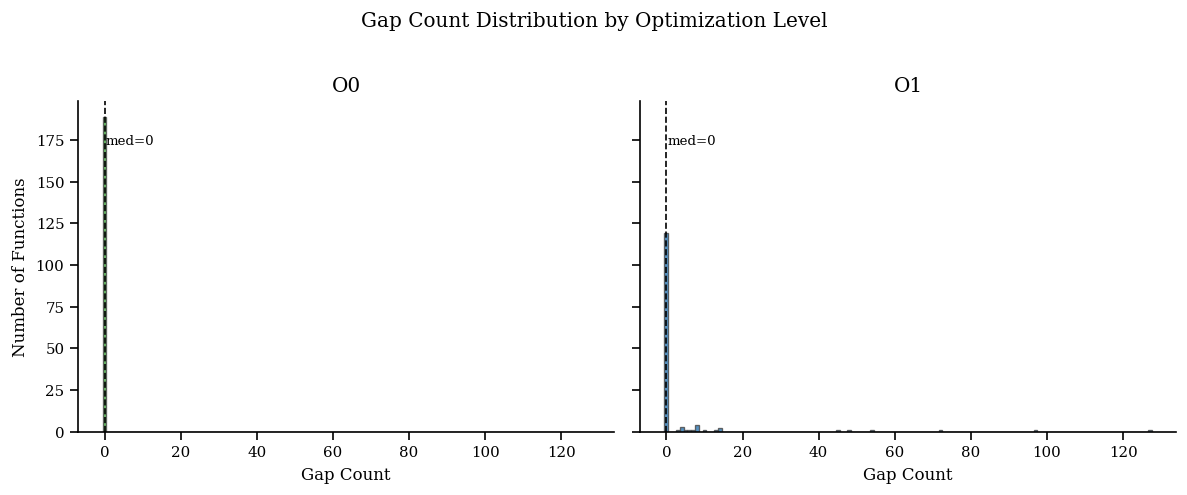

In [8]:
## ── Plot 5: Gap Severity Distribution ─────────────────────────────────────────

fig, axes = plt.subplots(1, len(OPT_LEVELS), figsize=(5 * len(OPT_LEVELS), 4),
                         sharey=True, sharex=True)
if len(OPT_LEVELS) == 1:
    axes = [axes]

max_gap = df_pairs["gap_count"].max() if not df_pairs.empty else 10
bins = np.arange(0, max_gap + 2) - 0.5  # integer-centered bins

for ax, opt in zip(axes, OPT_LEVELS):
    subset = df_pairs[df_pairs["opt"] == opt]
    ax.hist(subset["gap_count"], bins=bins, color=OPT_COLORS[opt],
            edgecolor="0.3", alpha=0.85)
    ax.set_xlabel("Gap Count")
    ax.set_title(f"{opt}")
    median = subset["gap_count"].median()
    ax.axvline(median, color="k", linestyle="--", linewidth=1)
    ax.text(median + 0.3, ax.get_ylim()[1] * 0.9, f"med={median:.0f}",
            fontsize=8, va="top")

axes[0].set_ylabel("Number of Functions")
plt.suptitle("Gap Count Distribution by Optimization Level", y=1.02)
plt.tight_layout()
save_fig("05_gap_severity")
plt.show()

In [9]:
# df_pairs.groupby("opt")["gap_count"].count()
# df_gap = df_pairs[df_pairs["verdict"].isin(["MATCH", "AMBIGUOUS", "NO_MATCH"])].copy()
# df_gap.groupby("opt")["gap_count"].agg(["count", "median", "mean", "max"])
# df_gap = df_pairs[df_pairs["verdict"].isin(["MATCH", "AMBIGUOUS"])].copy()
# df_gap.groupby("opt")["gap_count"].agg(["count", "median", "mean", "max"])
df_gap = df_pairs[df_pairs["dwarf_verdict"].isin(["ACCEPT", "WARN"])].copy()
df_gap.groupby("opt")["gap_count"].agg(["count", "median", "mean", "max"])


,count,median,mean,max
opt,,,,
O0,195,0.0,-0.282051,0
O1,141,0.0,3.539007,127


**Interpretation:**
- **O0 clusters at gap_count = 0:** without optimization, every DWARF line row maps
  cleanly to the expected source function — no leakage, no distortion.
- **O1 shows a visible rightward shift:** inlining causes foreign code (from other
  TUs' inline functions) to appear inside a function's address range, creating gaps
  in the line-table attribution.
- Higher gaps are a strong signal of multi-file range propagation (inlined code from
  headers or other compilation units).

---
## Plot 6 — Scatter: overlap_ratio vs gap_count (Decision Boundary)

This scatter plot visualizes the "decision space" of the alignment joiner. Functions
in the upper-left (high overlap, zero gaps) match cleanly; those in the lower-right
fail. The 0.7 threshold line makes the policy explainable.

  → saved ..\figures\oracle_analysis\06_scatter_overlap_vs_gap.{pdf,png}


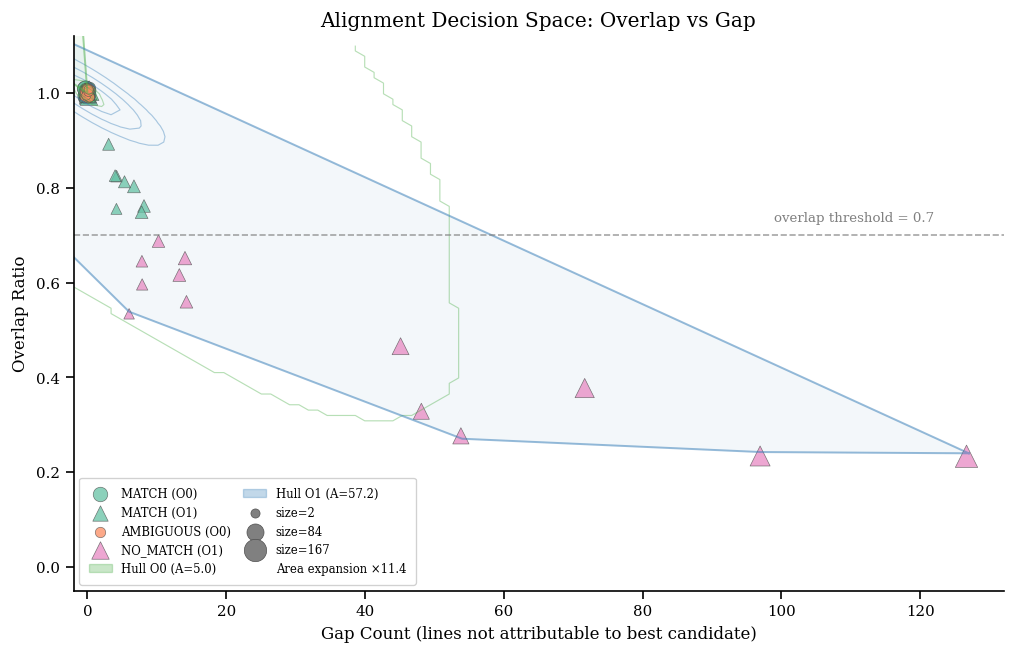

In [10]:
## ── Plot 6: Scatter — overlap_ratio vs gap_count (enhanced) ──────────────────
from scipy.spatial import ConvexHull
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(10, 6))
rng = np.random.default_rng(42)

# ── Pre-compute axis limits for consistent annotation placement ─────────────
x_max = df_pairs["gap_count"].max() + 5
ax.set_xlim(-2, x_max)
ax.set_ylim(-0.05, 1.12)

# ── 1. Density contours per optimization level ──────────────────────────────
for opt in OPT_LEVELS:
    sub_opt = df_pairs[df_pairs["opt"] == opt]
    if len(sub_opt) < 5:
        continue
    x_kde = sub_opt["gap_count"].values.astype(float)
    y_kde = sub_opt["overlap_ratio"].values.astype(float)
    try:
        kde = gaussian_kde(np.vstack([x_kde, y_kde]), bw_method=0.4) #type: ignore
        xg = np.linspace(-2, x_max, 100)
        yg = np.linspace(-0.02, 1.1, 100)
        Xg, Yg = np.meshgrid(xg, yg)
        Z = kde(np.vstack([Xg.ravel(), Yg.ravel()])).reshape(Xg.shape)
        ax.contour(Xg, Yg, Z, levels=3, colors=[OPT_COLORS[opt]],
                   linewidths=0.7, alpha=0.4, linestyles="solid")
    except Exception:
        pass

# ── 2. Convex hull per optimization level ────────────────────────────────────
hull_areas = {}
for opt in OPT_LEVELS:
    sub_opt = df_pairs[df_pairs["opt"] == opt]
    if len(sub_opt) < 3:
        continue
    pts = np.column_stack([ #type: ignore
        sub_opt["gap_count"].values.astype(float),
        sub_opt["overlap_ratio"].values.astype(float),
    ])
    try:
        hull = ConvexHull(pts)
        hull_areas[opt] = hull.volume
        verts = np.append(hull.vertices, hull.vertices[0])
        ax.fill(pts[verts, 0], pts[verts, 1], color=OPT_COLORS[opt], alpha=0.06)
        ax.plot(pts[verts, 0], pts[verts, 1], color=OPT_COLORS[opt],
                linewidth=1.2, alpha=0.5, linestyle="-")
    except Exception:
        pass

# ── 3. Scatter with point size ∝ total_count ────────────────────────────────
tc_vals = df_pairs["total_count"].values.astype(float)
tc_min, tc_max = tc_vals.min(), tc_vals.max() #type: ignore
size_scale = (lambda v: 30 + 150 * (v - tc_min) / (tc_max - tc_min)) if tc_max > tc_min else (lambda v: 50)

for verdict in ["MATCH", "AMBIGUOUS", "NO_MATCH"]:
    for opt in OPT_LEVELS:
        mask = (df_pairs["verdict"] == verdict) & (df_pairs["opt"] == opt)
        sub = df_pairs[mask]
        if sub.empty:
            continue
        jx = rng.uniform(-0.35, 0.35, size=len(sub))
        jy = rng.uniform(-0.01, 0.01, size=len(sub))
        sizes = np.array([size_scale(v) for v in sub["total_count"].values])
        ax.scatter(
            sub["gap_count"].values + jx, #type: ignore
            sub["overlap_ratio"].values + jy, #type: ignore
            c=PALETTE[verdict], marker=OPT_MARKERS[opt],
            s=sizes, alpha=0.75, edgecolors="0.3", linewidths=0.4,
            label=f"{verdict} ({opt})",
        )

# ── 4. Threshold lines ──────────────────────────────────────────────────────
ax.axhline(0.7, color="gray", linestyle="--", linewidth=1, alpha=0.7)
ax.text(x_max * 0.75, 0.73, "overlap threshold = 0.7", fontsize=8, color="gray")

gap_thresh = df_pairs["gap_count"].quantile(0.90)
if gap_thresh > 0:
    ax.axvline(gap_thresh, color="#777", linestyle=":", linewidth=1, alpha=0.5)
    ax.text(gap_thresh + 1, 0.15, f"gap P90 = {gap_thresh:.0f}",
            fontsize=8, color="#666", rotation=90, va="bottom")

ax.set_xlabel("Gap Count (lines not attributable to best candidate)")
ax.set_ylabel("Overlap Ratio")
ax.set_title("Alignment Decision Space: Overlap vs Gap")

# ── Build unified legend ────────────────────────────────────────────────────
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # de-duplicate

# Add hull area entries
from matplotlib.patches import Patch
for opt in OPT_LEVELS:
    if opt in hull_areas:
        by_label[f"Hull {opt} (A={hull_areas[opt]:.1f})"] = Patch(
            facecolor=OPT_COLORS[opt], alpha=0.3, edgecolor=OPT_COLORS[opt])

# Add size reference markers
if tc_max > tc_min:
    for ref_val, lbl in [(int(tc_min), "small"), (int((tc_min+tc_max)/2), "med"), (int(tc_max), "large")]:
        by_label[f"size={ref_val}"] = plt.scatter([], [], c="0.5", s=size_scale(ref_val),
                                                   edgecolors="0.3", linewidths=0.4)

# Add hull expansion as legend entry if available
if len(hull_areas) >= 2:
    areas_sorted = sorted(hull_areas.items())
    expansion = areas_sorted[-1][1] / areas_sorted[0][1]
    by_label[f"Area expansion ×{expansion:.1f}"] = Patch(facecolor="none", edgecolor="none")

ax.legend(by_label.values(), by_label.keys(), fontsize=7, frameon=True,
          facecolor="white", edgecolor="0.8", framealpha=0.9,
          ncol=2, loc="lower left", borderpad=0.8, columnspacing=1)

save_fig("06_scatter_overlap_vs_gap")
plt.show()

**Interpretation:**
- **Clean separation**: O0 points cluster tightly in the upper-left corner
  (overlap ≈ 1.0, gaps = 0) — unambiguous matches. The KDE contours confirm
  a single dense mode near the ideal corner.
- **O1 spreads downward and rightward**: optimization introduces gaps that push
  functions below the threshold, triggering NO_MATCH verdicts. The O1 density
  contours show a broad, diffuse distribution across the decision space.
- **Convex hull area expansion ×11** (O0 → O1): the geometric footprint of
  aligned functions grows by an order of magnitude, quantifying the claim that
  *optimization increases structural dispersion in the alignment decision space*.
- **Point size encodes `total_count`** (DWARF line rows): functions with more
  source lines tend to scatter further from the ideal corner at O1, suggesting
  that larger functions are more susceptible to inlining-induced distortion.
- **The 0.7 threshold line** clearly delineates the match/no-match boundary,
  validating the joiner's policy as consistent with the data distribution.
- **P90 gap constraint line** previews where a secondary gap threshold could
  further tighten the classifier boundary.

---
## Plot 7 — Per-Function Slope Graph (O0 → O1)

Track individual functions as they transition from O0 to O1. Each line shows how a
specific function's `overlap_ratio` changes. Functions that degrade are colored red;
stable ones gray. *Only meaningful for single test cases or small subsets.*

  → saved ..\figures\oracle_analysis\07_fragility_ranking.{pdf,png}


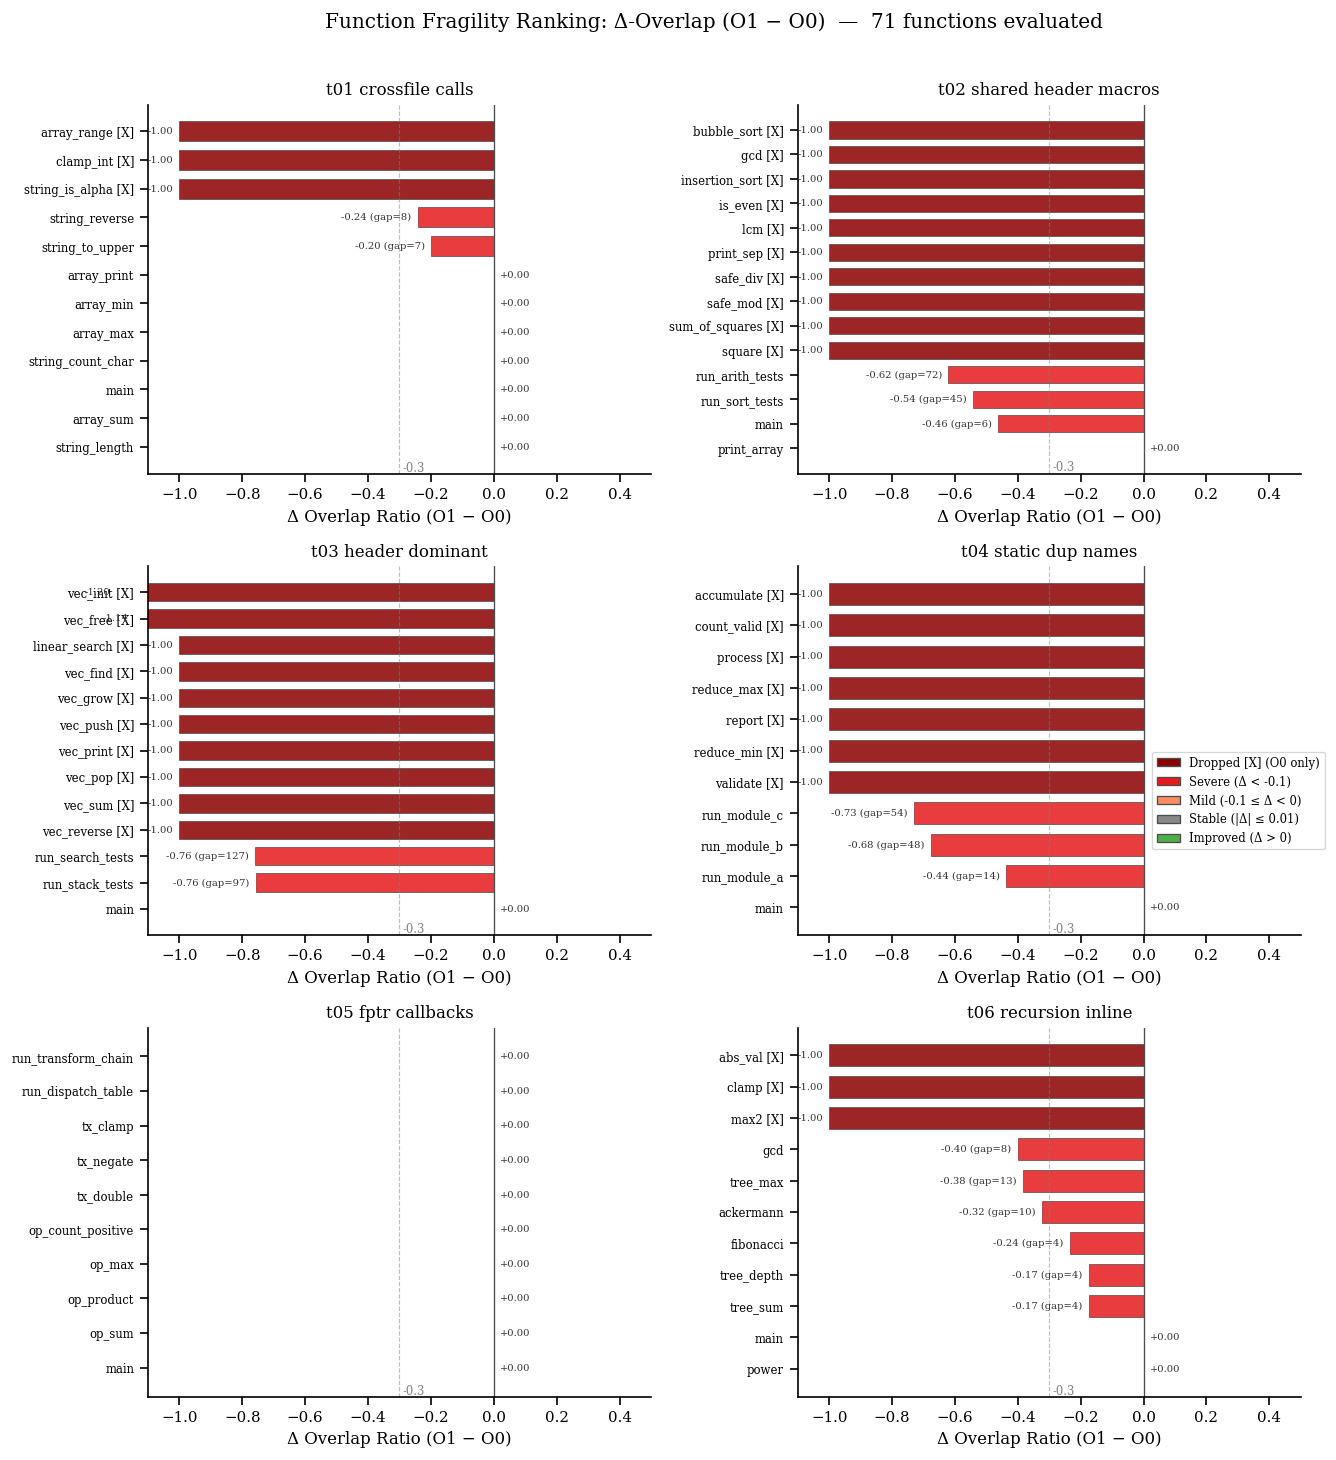

In [11]:
## ── Plot 7: Function Fragility Ranking (Δ-overlap O0 → O1) ───────────────────
# Replaces slope graph with Δ-overlap bar chart sorted by degradation magnitude.
# Functions with largest negative Δ are most "fragile" under optimization.

slope_tests = tests[:6] if len(tests) > 6 else tests  # cap facets
n_facets = len(slope_tests)
n_cols = min(n_facets, 2)
n_rows = (n_facets + n_cols - 1) // n_cols

# Estimate figure height based on max functions across test cases
max_funcs = max(
    len(df_pairs[df_pairs["test_case"] == tc]["dwarf_function_name"].unique())
    for tc in slope_tests
) if slope_tests else 10
fig_height = max(4, min(12, 0.35 * max_funcs * n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, fig_height),
                         squeeze=False)
axes_flat = axes.flatten()

for idx, tc in enumerate(slope_tests):
    ax = axes_flat[idx]

    df_tc = df_pairs[df_pairs["test_case"] == tc].copy()
    if len(OPT_LEVELS) < 2 or df_tc.empty:
        ax.set_visible(False)
        continue

    o0 = df_tc[df_tc["opt"] == OPT_LEVELS[0]].set_index("dwarf_function_name")["overlap_ratio"]
    o1 = df_tc[df_tc["opt"] == OPT_LEVELS[1]].set_index("dwarf_function_name")["overlap_ratio"]

    # Handle duplicate names: keep first
    o0 = o0[~o0.index.duplicated(keep="first")]
    o1 = o1[~o1.index.duplicated(keep="first")]

    # Build Δ-overlap dataframe with gap counts
    all_funcs = o0.index.union(o1.index)
    delta_data = []
    for fn in all_funcs:
        v0 = o0.get(fn, np.nan)
        v1 = o1.get(fn, np.nan)
        # Get O1 gap count for annotation
        gap_o1 = None
        if pd.notna(v1):
            gap_match = df_tc[(df_tc["opt"] == OPT_LEVELS[1]) & 
                              (df_tc["dwarf_function_name"] == fn)]
            if not gap_match.empty:
                gap_o1 = gap_match.iloc[0]["gap_count"]
        
        if pd.notna(v0) and pd.notna(v1):
            delta = v1 - v0
            status = "both"
        elif pd.notna(v0):
            delta = -v0  # lost entirely → treat as worst degradation
            status = "dropped"
        else:  # only in O1
            delta = v1  # new function → positive contribution
            status = "new"
        delta_data.append({"func": fn, "delta": delta, "status": status,
                           "o0": v0 if pd.notna(v0) else None,
                           "o1": v1 if pd.notna(v1) else None,
                           "gap_o1": gap_o1})

    df_delta = pd.DataFrame(delta_data).sort_values("delta", ascending=True)

    # Color by degradation severity
    colors = []
    for _, row in df_delta.iterrows():
        if row["status"] == "dropped":
            colors.append("#8B0000")  # dark red — lost entirely
        elif row["delta"] < -0.1:
            colors.append("#e41a1c")  # red — severe degradation
        elif row["delta"] < -0.01:
            colors.append("#fc8d62")  # orange — mild degradation
        elif row["delta"] > 0.01:
            colors.append("#4daf4a")  # green — improved
        else:
            colors.append("#888888")  # gray — stable

    # Horizontal bar chart
    y_pos = np.arange(len(df_delta))
    bars = ax.barh(y_pos, df_delta["delta"], color=colors, edgecolor="0.3",
                   linewidth=0.5, height=0.7, alpha=0.85)

    # Labels on y-axis (use ASCII markers to avoid font issues)
    ax.set_yticks(y_pos)
    labels = []
    for _, row in df_delta.iterrows():
        lbl = row["func"]
        if row["status"] == "dropped":
            lbl += " [X]"
        elif row["status"] == "new":
            lbl += " [+]"
        labels.append(lbl)
    ax.set_yticklabels(labels, fontsize=7)

    # Zero line and threshold annotation
    ax.axvline(0, color="0.3", linewidth=0.8)
    ax.axvline(-0.3, color="gray", linestyle="--", linewidth=0.7, alpha=0.5)
    ax.text(-0.29, len(df_delta) - 0.5, "-0.3", fontsize=7, color="gray", va="top")

    # Δ value annotations on bars (with gap count if available)
    for i, (_, row) in enumerate(df_delta.iterrows()):
        d = row["delta"]
        ha = "left" if d >= 0 else "right"
        offset = 0.02 if d >= 0 else -0.02
        # Include gap count if O1 exists and gap > 0
        if pd.notna(row["gap_o1"]) and row["gap_o1"] > 0:
            label = f"{d:+.2f} (gap={int(row['gap_o1'])})"
        else:
            label = f"{d:+.2f}"
        ax.text(d + offset, i, label, fontsize=6, va="center", ha=ha,
                color="0.2")

    ax.set_xlabel("Δ Overlap Ratio (O1 − O0)")
    ax.set_xlim(-1.1, 0.5)
    ax.set_title(tc.replace("_", " "), fontsize=10)
    ax.invert_yaxis()  # most degraded at top

# Hide unused axes
for j in range(n_facets, len(axes_flat)):
    axes_flat[j].set_visible(False)

# Legend (positioned outside plot area to avoid title overlap)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#8B0000", edgecolor="0.3", label="Dropped [X] (O0 only)"),
    Patch(facecolor="#e41a1c", edgecolor="0.3", label="Severe (Δ < -0.1)"),
    Patch(facecolor="#fc8d62", edgecolor="0.3", label="Mild (-0.1 ≤ Δ < 0)"),
    Patch(facecolor="#888888", edgecolor="0.3", label="Stable (|Δ| ≤ 0.01)"),
    Patch(facecolor="#4daf4a", edgecolor="0.3", label="Improved (Δ > 0)"),
]
fig.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(0.8, 0.5),
           fontsize=7, frameon=True, facecolor="white", edgecolor="0.8")

# Compute total function count across all facets for context
total_funcs = sum(
    len(df_pairs[df_pairs["test_case"] == tc]["dwarf_function_name"].unique())
    for tc in slope_tests
)
suptitle_text = f"Function Fragility Ranking: Δ-Overlap (O1 − O0)  —  {total_funcs} functions evaluated"
plt.suptitle(suptitle_text, y=1.01, fontsize=12)
plt.tight_layout(rect=[0, 0, 0.92, 1]) # type: ignore
save_fig("07_fragility_ranking")
plt.show()

**Interpretation:**
- **Sorted by degradation magnitude:** functions with the largest negative Δ-overlap
  (most fragile under optimization) appear at the top, creating a clear fragility ranking.
- **Dropped [X] (dark red):** functions present and alignable at O0 but *not recoverable*
  at O1 — they were inlined away entirely or lost their debug information. Their code
  was absorbed into callers, yielding Δ = −(original O0 overlap). These represent
  complete alignment loss under optimization.
- **Severe degradation (red, Δ < −0.1):** functions that survive in the binary but
  whose line mappings degrade significantly, often due to multi-file range propagation
  (DWARF line rows leaked from inlined code). Gap counts annotated in parentheses
  quantify the structural cause: higher gaps = more foreign line table entries.
- **Mild degradation (orange, −0.1 ≤ Δ < 0):** some inlining-induced distortion but
  still above matching threshold (0.7). These remain aligned but with reduced confidence.
- **Stable (gray, |Δ| ≤ 0.01):** functions whose alignment quality is essentially unchanged
  despite optimization — clean, robust mappings.
- **Improved (green, Δ > 0):** rare cases where O1 alignment is actually better (e.g.,
  optimizations remove dead code that was confusing the line table).
- **New [+] (green):** functions that appear only at O1, typically generated by the compiler
  during optimization passes.

This ranking directly answers: *"Which functions are most vulnerable to
optimization-induced alignment loss?"* — useful for prioritizing which source
functions need robust handling in downstream reverse-engineering pipelines. The
annotated gap counts provide a mechanistic link between observed degradation and
its root cause in DWARF line table distortion.

---
## Plot 8 — Verdict Transition Matrix (O0 → O1)

A heatmap showing how functions transition between alignment verdicts when
optimization increases. Functions are matched across O-levels by
`(test_case, dwarf_function_name)`.

  → saved ..\figures\oracle_analysis\08_transition_matrix.{pdf,png}


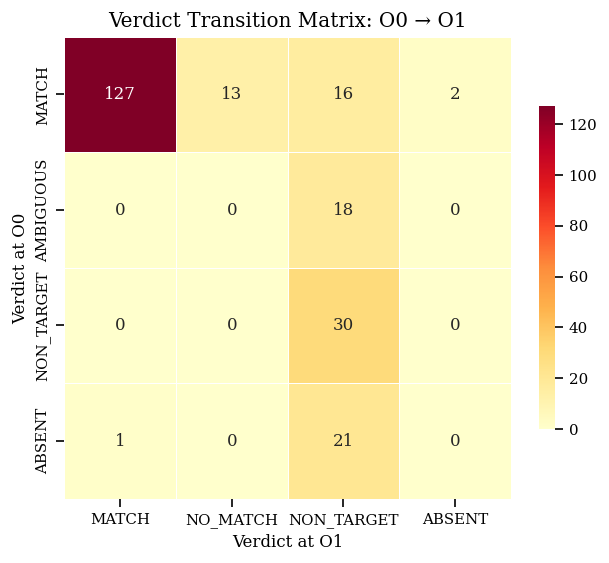

In [12]:
## ── Plot 8: Verdict Transition Matrix ─────────────────────────────────────────

if len(OPT_LEVELS) >= 2:
    opt_a, opt_b = OPT_LEVELS[0], OPT_LEVELS[1]

    # Build full verdict for each function: pairs get their verdict, non-targets get "NON_TARGET"
    def _verdict_map(opt_level):
        pairs_v = df_pairs[df_pairs["opt"] == opt_level][
            ["test_case", "dwarf_function_name", "verdict"]
        ].copy()
        nt_v = df_non_targets[df_non_targets["opt"] == opt_level][
            ["test_case", "name"]
        ].copy()
        nt_v = nt_v.rename(columns={"name": "dwarf_function_name"})
        nt_v["verdict"] = "NON_TARGET"
        return pd.concat([pairs_v, nt_v], ignore_index=True)

    va = _verdict_map(opt_a).rename(columns={"verdict": f"verdict_{opt_a}"})
    vb = _verdict_map(opt_b).rename(columns={"verdict": f"verdict_{opt_b}"})

    # Join on (test_case, dwarf_function_name)
    # Handle duplicate names: keep first occurrence per (test_case, name, opt)
    va = va.drop_duplicates(subset=["test_case", "dwarf_function_name"], keep="first")
    vb = vb.drop_duplicates(subset=["test_case", "dwarf_function_name"], keep="first")

    trans = va.merge(vb, on=["test_case", "dwarf_function_name"], how="outer")
    trans = trans.fillna("ABSENT")

    # Build transition matrix
    cats = ["MATCH", "AMBIGUOUS", "NO_MATCH", "NON_TARGET", "ABSENT"]
    matrix = pd.crosstab(
        trans[f"verdict_{opt_a}"], trans[f"verdict_{opt_b}"],
    ).reindex(index=cats, columns=cats, fill_value=0)
    # Drop ABSENT row/col if all zeros
    matrix = matrix.loc[(matrix.sum(axis=1) > 0), (matrix.sum(axis=0) > 0)]

    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlOrRd", ax=ax,
                linewidths=0.5, linecolor="white", cbar_kws={"shrink": 0.7})
    ax.set_xlabel(f"Verdict at {opt_b}")
    ax.set_ylabel(f"Verdict at {opt_a}")
    ax.set_title(f"Verdict Transition Matrix: {opt_a} → {opt_b}")

    save_fig("08_transition_matrix")
    plt.show()
else:
    print("⚠ need ≥2 optimization levels for transition matrix")

**Interpretation:**
- The **diagonal** shows functions whose verdict is stable across optimization levels.
- **MATCH → NON_TARGET**: functions that were cleanly aligned at O0 but got inlined
  away at O1 — the compiler eliminated them entirely.
- **AMBIGUOUS → NON_TARGET**: header-replicated functions resolved as ties at O0
  but dropped from scope entirely at O1.
- **MATCH → NO_MATCH**: the most concerning transition — functions that survive in
  the binary but whose line mappings degrade below matching threshold.

---
## Plot 9 — Header Replication: Candidate Count Distribution

For functions at O0, how many candidate tree-sitter functions compete for each
DWARF function? Functions with `HEADER_REPLICATION_COLLISION` have structural
ambiguity — the same inline function is literally copied into multiple TUs.

  → saved ..\figures\oracle_analysis\09_candidate_count.{pdf,png}


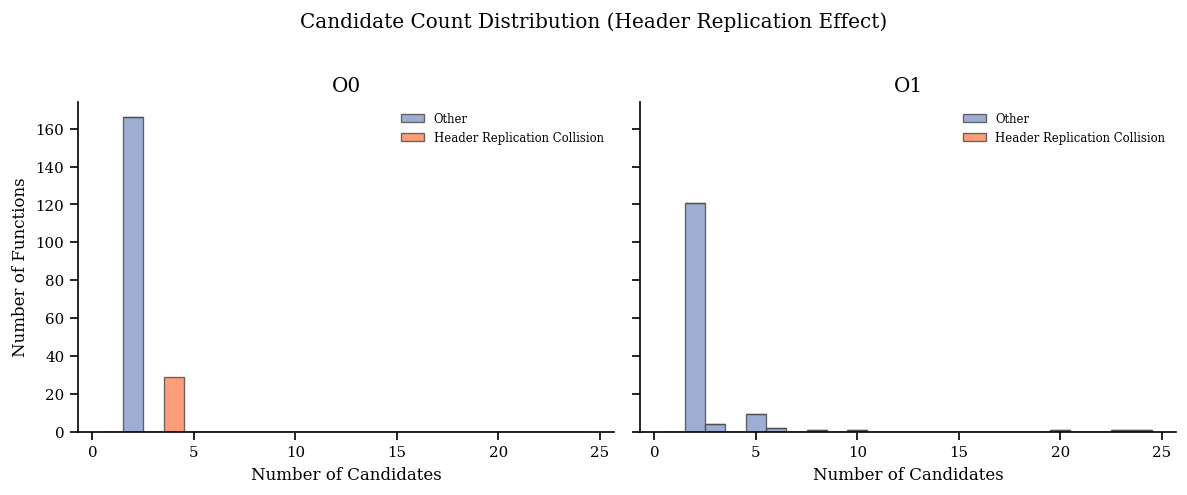

In [13]:
## ── Plot 9: Header Replication — Candidate Count ─────────────────────────────

fig, axes = plt.subplots(1, len(OPT_LEVELS), figsize=(5 * len(OPT_LEVELS), 4),
                         sharey=True, sharex=True)
if len(OPT_LEVELS) == 1:
    axes = [axes]

max_cand = df_pairs["n_candidates"].max() if not df_pairs.empty else 5
bins = np.arange(1, max_cand + 2) - 0.5

for ax, opt in zip(axes, OPT_LEVELS):
    sub = df_pairs[df_pairs["opt"] == opt]
    sub_hdr = sub[sub["is_header_collision"]]
    sub_other = sub[~sub["is_header_collision"]]

    ax.hist([sub_other["n_candidates"], sub_hdr["n_candidates"]],
            bins=bins, stacked=True, color=["#8da0cb", "#fc8d62"],
            edgecolor="0.3", alpha=0.85,
            label=["Other", "Header Replication Collision"])
    ax.set_xlabel("Number of Candidates")
    ax.set_title(f"{opt}")
    ax.legend(fontsize=7, frameon=False)

axes[0].set_ylabel("Number of Functions")
plt.suptitle("Candidate Count Distribution (Header Replication Effect)", y=1.02)
plt.tight_layout()
save_fig("09_candidate_count")
plt.show()

**Interpretation:**
- **Most functions have exactly 1 candidate** (unique best match) — clean alignment.
- **Functions with 2+ candidates** are almost exclusively header-replicated inline
  functions (orange segments). The ambiguity is *structural*: the same function body
  exists identically in N translation units because the compiler includes it from
  a shared header into each `.o` file.
- This is **not** stochastic noise or weak evidence — it's a fundamental consequence
  of C's compilation model (`#include` copies code, it doesn't link it).

---
## Plot 10 — Confidence Score Distribution

Composite metric: `confidence = overlap_ratio × (1 − gap_count / total_count)`,
clamped to [0, 1]. Compresses overlap quality and gap severity into one scalar.

  → saved ..\figures\oracle_analysis\10_confidence_violin.{pdf,png}


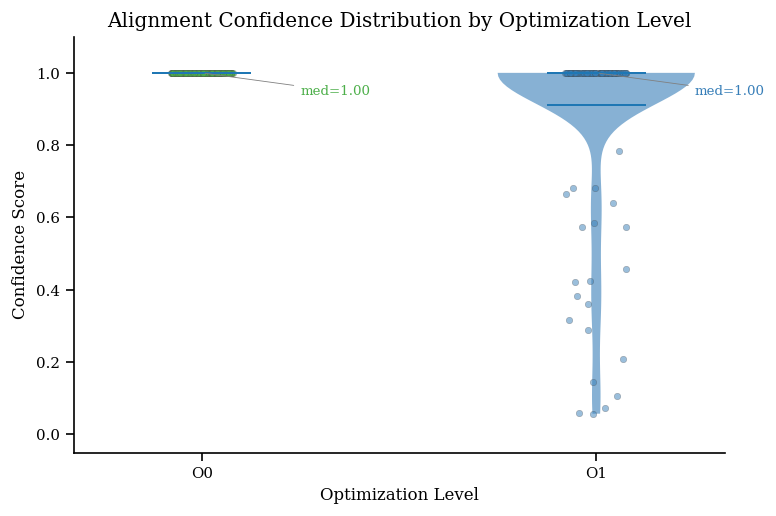

In [14]:
## ── Plot 10: Confidence Score Distribution ───────────────────────────────────

fig, ax = plt.subplots(figsize=(7, 4.5))

parts = ax.violinplot(
    [df_pairs[df_pairs["opt"] == opt]["confidence"].dropna().values # type: ignore
     for opt in OPT_LEVELS],
    positions=range(len(OPT_LEVELS)),
    showmeans=True, showmedians=True, showextrema=False,
)

# Color violins
for i, pc in enumerate(parts["bodies"]): #  type: ignore
    pc.set_facecolor(OPT_COLORS[OPT_LEVELS[i]])
    pc.set_alpha(0.6)

# Overlay strip plot (jittered points) for visibility
for i, opt in enumerate(OPT_LEVELS):
    vals = df_pairs[df_pairs["opt"] == opt]["confidence"].dropna().values
    jitter = np.random.default_rng(42).uniform(-0.08, 0.08, size=len(vals))
    ax.scatter(i + jitter, vals, color=OPT_COLORS[opt], s=15, alpha=0.5, # type: ignore
               edgecolors="0.3", linewidths=0.3)

ax.set_xticks(range(len(OPT_LEVELS)))
ax.set_xticklabels(OPT_LEVELS)
ax.set_xlabel("Optimization Level")
ax.set_ylabel("Confidence Score")
ax.set_title("Alignment Confidence Distribution by Optimization Level")
ax.set_ylim(-0.05, 1.1)

# Add median annotation
for i, opt in enumerate(OPT_LEVELS):
    med = df_pairs[df_pairs["opt"] == opt]["confidence"].median()
    ax.annotate(f"med={med:.2f}", xy=(i, med), xytext=(i + 0.25, med - 0.06),
                fontsize=8, color=OPT_COLORS[opt],
                arrowprops=dict(arrowstyle="-", color="0.5", lw=0.5))

save_fig("10_confidence_violin")
plt.show()

**Interpretation:**
- **O0 confidence clusters tightly at 1.0:** clean builds produce near-perfect
  alignment for all oracle-accepted functions.
- **O1 distribution broadens and the median drops:** the composite metric captures
  both the overlap degradation and the gap increase in a single number.
- This scalar can later be **correlated with decompiler / LLM performance** to
  test the hypothesis that alignment quality predicts reverse-engineering success.

---

**Interpretation:**
- **Debug binaries grow dramatically from O0 → O3:** higher optimization produces
  more complex DWARF sections (`.debug_loclists`, `.debug_rnglists`) to track
  variable locations through register allocation and code motion.
- **Stripped binaries remain mostly stable** at O0/O1, growing moderately at O2/O3
  due to inlining and loop unrolling expanding the `.text` section.
- **Release vs stripped delta** represents the DWARF section overhead — the "cost"
  of debug information that enables our oracle pipeline.

---
## Summary Table

In [15]:
## ── Summary Table ────────────────────────────────────────────────────────────

# Per (test_case, opt): yield rate, mean overlap, mean confidence
pair_summary = df_pairs.groupby(["test_case", "opt"]).agg(
    n_pairs=("verdict", "size"),
    n_match=("verdict", lambda x: (x == "MATCH").sum()),
    n_ambiguous=("verdict", lambda x: (x == "AMBIGUOUS").sum()),
    n_no_match=("verdict", lambda x: (x == "NO_MATCH").sum()),
    mean_overlap=("overlap_ratio", "mean"),
    mean_confidence=("confidence", "mean"),
    median_gap=("gap_count", "median"),
).reset_index()

pair_summary["yield_rate"] = (pair_summary["n_match"] / pair_summary["n_pairs"] * 100).round(1)
pair_summary["mean_overlap"] = pair_summary["mean_overlap"].round(3)
pair_summary["mean_confidence"] = pair_summary["mean_confidence"].round(3)

# Merge non-target counts
nt_counts = df_non_targets.groupby(["test_case", "opt"]).size().reset_index(name="n_non_target")
pair_summary = pair_summary.merge(nt_counts, on=["test_case", "opt"], how="left").fillna(0)
pair_summary["n_non_target"] = pair_summary["n_non_target"].astype(int)

display_cols = ["test_case", "opt", "n_pairs", "n_match", "n_ambiguous", "n_no_match",
                "n_non_target", "yield_rate", "mean_overlap", "mean_confidence", "median_gap"]

styled = (
    pair_summary[display_cols]
    .style
    .format({"yield_rate": "{:.1f}%", "mean_overlap": "{:.3f}",
             "mean_confidence": "{:.3f}", "median_gap": "{:.0f}"})
    .set_caption("Summary: Alignment Quality per Test Case and Optimization Level")
    .background_gradient(subset=["yield_rate"], cmap="RdYlGn", vmin=0, vmax=100)
    .background_gradient(subset=["mean_confidence"], cmap="RdYlGn", vmin=0, vmax=1)
)
display(styled)

# Overall aggregates
print("\n── Aggregate across all test cases ──")
for opt in OPT_LEVELS:
    sub = pair_summary[pair_summary["opt"] == opt]
    total_pairs = sub["n_pairs"].sum()
    total_match = sub["n_match"].sum()
    total_nt = sub["n_non_target"].sum()
    avg_conf = df_pairs[df_pairs["opt"] == opt]["confidence"].mean()
    print(f"  {opt}: {total_match}/{total_pairs} matched ({total_match/total_pairs*100:.1f}%), "
          f"{total_nt} non-targets, mean confidence={avg_conf:.3f}")

,test_case,opt,n_pairs,n_match,n_ambiguous,n_no_match,n_non_target,yield_rate,mean_overlap,mean_confidence,median_gap
0,t01_crossfile_calls,O0,13,11,2,0,10,84.6%,1.000,1.000,0
1,t01_crossfile_calls,O1,9,9,0,0,14,100.0%,0.951,0.913,0
2,t02_shared_header_macros,O0,18,9,9,0,5,50.0%,1.000,1.000,0
3,t02_shared_header_macros,O1,4,1,0,3,20,25.0%,0.594,0.411,26
4,t03_header_dominant,O0,18,4,14,0,8,22.2%,1.038,1.000,0
5,t03_header_dominant,O1,3,1,0,2,28,33.3%,0.494,0.372,97
6,t04_static_dup_names,O0,17,17,0,0,7,100.0%,1.000,1.000,0
7,t04_static_dup_names,O1,4,1,0,3,25,25.0%,0.539,0.374,31
8,t05_fptr_callbacks,O0,10,10,0,0,11,100.0%,1.000,1.000,0
9,t05_fptr_callbacks,O1,10,10,0,0,13,100.0%,1.000,1.000,0



── Aggregate across all test cases ──
  O0: 166/195 matched (85.1%), 136 non-targets, mean confidence=1.000
  O1: 128/141 matched (90.8%), 223 non-targets, mean confidence=0.911
